In [ ]:
import spacy
import random
import json
import matplotlib.pyplot as plt
from spacy.util import minibatch
from spacy.training.example import Example
from spacy.lookups import Lookups
from pathlib import Path

# === Load training data ===
with open("03_Label/spacy_training_data_sentences.json", "r", encoding="utf-8") as f:
    raw_data = json.load(f)

training_data = [
    (item["text"], {"entities": [tuple(ent) for ent in item["entities"]]})
    for item in raw_data
]

# === Lexeme normalization lookup ===
lexeme_norm_data = {
    "Gemeinden": "Gemeinde",
    "Kantons": "Kanton",
    "Kantone": "Kanton",
    "Bezirke": "Bezirk",
}

# === Setup base model ===
nlp = spacy.load("de_core_news_lg")

lookups = Lookups()
lookups.add_table("lexeme_norm", lexeme_norm_data)
nlp.vocab.lookups = lookups

ner = nlp.get_pipe("ner")

# Add entity labels
for _, ann in training_data:
    for ent in ann["entities"]:
        ner.add_label(ent[2])

examples = [Example.from_dict(nlp.make_doc(text), ann) for text, ann in training_data]

# === Training ===
loss_history = []
epochs = 10
base_output_dir = Path("02_Model/epoch_testing")
base_output_dir.mkdir(parents=True, exist_ok=True)

with nlp.disable_pipes(*[p for p in nlp.pipe_names if p != "ner"]):
    optimizer = nlp.resume_training()
    for epoch in range(1, epochs + 1):
        print(f"\n🔁 Epoch {epoch}")
        random.shuffle(examples)
        losses = {}
        for batch in minibatch(examples, size=64):
            nlp.update(batch, sgd=optimizer, drop=0.3, losses=losses)

        epoch_loss = losses.get("ner", 0)
        loss_history.append(epoch_loss)
        print(f"Loss after epoch {epoch}: {epoch_loss}")

        # Save model after this epoch
        epoch_path = base_output_dir / f"ner_model_after_epoch_{epoch}"
        epoch_path.mkdir(parents=True, exist_ok=True)
        nlp.to_disk(epoch_path)
        print(f"✅ Saved model: {epoch_path}")

# === Save final loss.json and plot ===
final_path = base_output_dir / "final_metrics"
final_path.mkdir(parents=True, exist_ok=True)

with open(final_path / "loss.json", "w") as f:
    json.dump(loss_history, f)

plt.figure()
plt.plot(range(1, epochs + 1), loss_history, marker="o")
plt.title("NER Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.savefig(final_path / "loss_plot.png")
plt.close()

print("✅ Saved final loss values and loss curve.")


In [6]:
import os
import re
import time
import pandas as pd
import spacy

# === Parameters ===
statistic_dataset = "05_Statistik/Statistischer_Test_Datensatz_v1.csv"
model_dir = "02_Model/epoch_testing"
output_csv = "05_Statistik/statistical_test_10_epochs.csv"

# === Load CSV ===
df = pd.read_csv(statistic_dataset)

# === Helper: Extract LOC entities ===
def extract_spacy_entities(text, model):
    if pd.isna(text):
        return []
    doc = model(text)
    return [ent.text for ent in doc.ents if ent.label_ == "LOC"]

# === Helper: Sort model folders numerically ===
def extract_epoch_number(name):
    match = re.search(r"epoch_(\d+)", name)
    return int(match.group(1)) if match else float("inf")

# === Collect and sort model directories ===
model_paths = sorted([
    name for name in os.listdir(model_dir)
    if os.path.isdir(os.path.join(model_dir, name))
], key=extract_epoch_number)

print(f"🔍 Found models: {model_paths}")

# === Process each model ===
for model_name in model_paths:
    print(f"\n🚀 Processing model: {model_name}")
    model_path = os.path.join(model_dir, model_name)

    try:
        nlp = spacy.load(model_path)
    except Exception as e:
        print(f"❌ Error loading {model_name}: {e}")
        continue

    loc_labels = []
    start = time.perf_counter()
    for _, row in df.iterrows():
        text = f"{row.get('dataset_title_de', '')} {row.get('dataset_description_de', '')}"
        loc_labels.append(extract_spacy_entities(text, nlp))
    end = time.perf_counter()

    df[model_name] = loc_labels
    print(f"✅ Done in {end - start:.2f} seconds – results stored in column '{model_name}'")

# === Save result CSV ===
df.to_csv(output_csv, index=False, encoding="utf-8")
print(f"\n✅ All results saved to: {output_csv}")


🔍 Found models: ['ner_model_after_epoch_1', 'ner_model_after_epoch_2', 'ner_model_after_epoch_3', 'ner_model_after_epoch_4', 'ner_model_after_epoch_5', 'ner_model_after_epoch_6', 'ner_model_after_epoch_7', 'ner_model_after_epoch_8', 'ner_model_after_epoch_9', 'ner_model_after_epoch_10', 'final_metrics']

🚀 Processing model: ner_model_after_epoch_1
✅ Done in 0.65 seconds – results stored in column 'ner_model_after_epoch_1'

🚀 Processing model: ner_model_after_epoch_2
✅ Done in 0.62 seconds – results stored in column 'ner_model_after_epoch_2'

🚀 Processing model: ner_model_after_epoch_3
✅ Done in 0.92 seconds – results stored in column 'ner_model_after_epoch_3'

🚀 Processing model: ner_model_after_epoch_4
✅ Done in 0.88 seconds – results stored in column 'ner_model_after_epoch_4'

🚀 Processing model: ner_model_after_epoch_5
✅ Done in 0.90 seconds – results stored in column 'ner_model_after_epoch_5'

🚀 Processing model: ner_model_after_epoch_6
✅ Done in 1.60 seconds – results stored in co

In [7]:
import pandas as pd
import ast
import re

# === CSV laden ===
comparison_csv = "05_Statistik/statistical_test_10_epochs.csv"
df = pd.read_csv(comparison_csv)

# --- Hilfsfunktionen ---
def to_list_with_not_found(value):
    if isinstance(value, list):
        return value if value else ['not_found']
    if pd.isna(value) or str(value).strip() == "":
        return ['not_found']
    items = [item.strip() for item in str(value).strip("[]").split(",") if item.strip()]
    return items if items else ['not_found']

def to_list_or_not_found(val):
    if pd.isna(val) or val == "":
        return ['not_found']
    if isinstance(val, list):
        return val if val else ['not_found']
    if isinstance(val, str):
        try:
            parsed = ast.literal_eval(val)
            if isinstance(parsed, list):
                return parsed if parsed else ['not_found']
        except Exception as e:
            print(f"❌ Fehler beim Parsen: {val} → {e}")
    return ['not_found']

def clean_text(text):
    if not isinstance(text, str):
        return ""
    return re.sub(r"[^\wäöüÄÖÜß\s]", "", text)

# --- Anwendung auf definierte Spalten ---
df["correct_location"] = df["correct_location"].apply(to_list_with_not_found)
df["semantic_location"] = df["semantic_location"].apply(to_list_with_not_found)

# Erweiterung auf alle NER-Modellspalten (beginnen mit 'ner_model_')
model_columns = [col for col in df.columns if col.startswith("ner_model_")]
for col in model_columns:
    df[col] = df[col].apply(to_list_or_not_found)

# all_words berechnen
df["all_words"] = (df["dataset_title_de"].apply(clean_text) + " " + df["dataset_description_de"].apply(clean_text)).str.split()

# # === Speichern ===
df.to_csv(comparison_csv, index=False, encoding="utf-8")
print(f"\n✅ Bereinigte Daten gespeichert unter: {comparison_csv}")



✅ Bereinigte Daten gespeichert unter: 05_Statistik/statistical_test_10_epochs.csv


🔍 Found model columns: ['ner_model_after_epoch_1', 'ner_model_after_epoch_2', 'ner_model_after_epoch_3', 'ner_model_after_epoch_4', 'ner_model_after_epoch_5', 'ner_model_after_epoch_6', 'ner_model_after_epoch_7', 'ner_model_after_epoch_8', 'ner_model_after_epoch_9', 'ner_model_after_epoch_10']


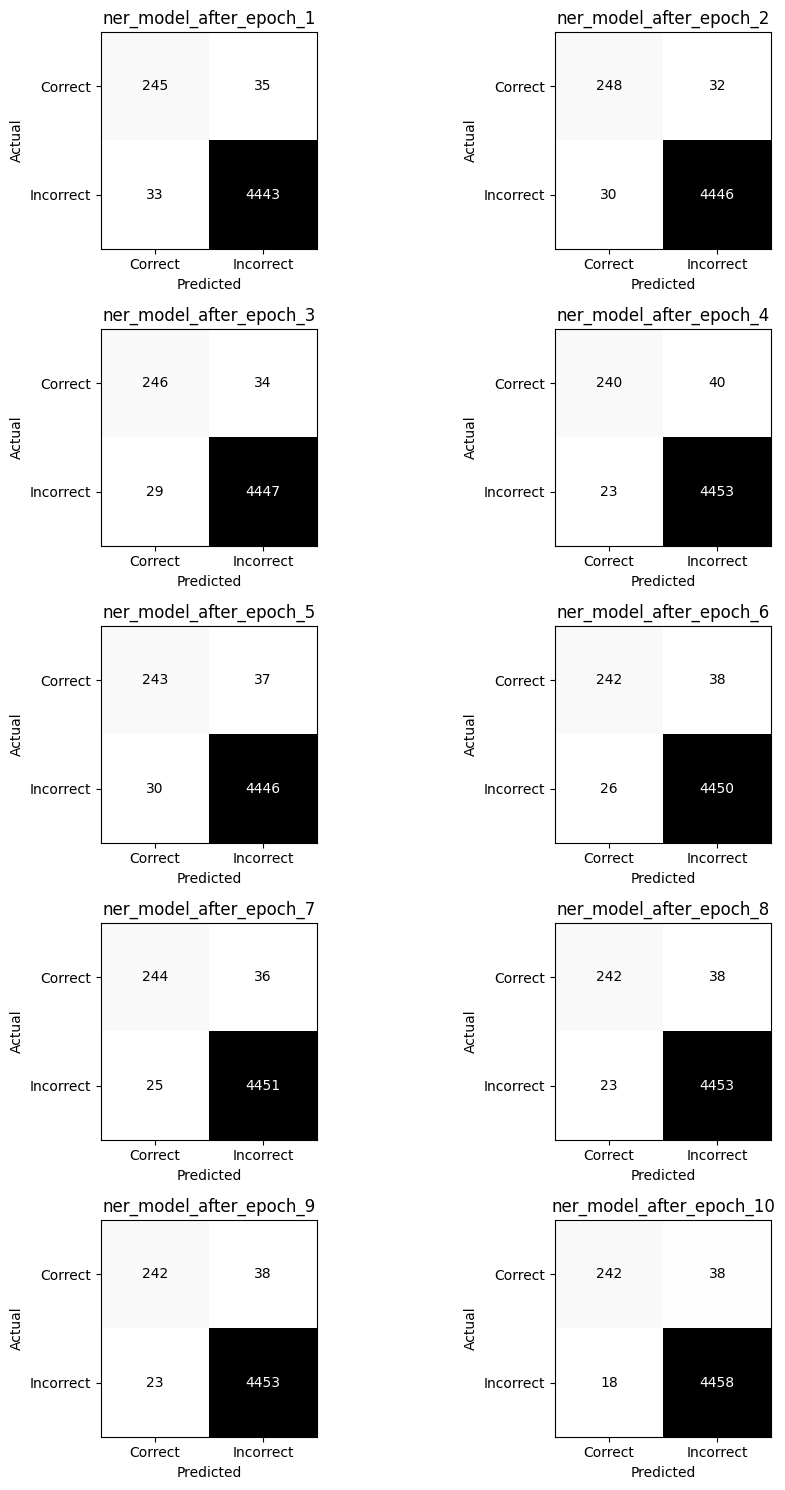

✅ Confusion matrix saved to: 05_Statistik/konfusionsmatrizen_10_epochs.png
✅ Precision/Recall/F1 saved to: 05_Statistik/loc_scores_data_10_epochs.csv
✅ Summary with accuracy saved to: 05_Statistik/loc_scores_summary_10_epochs.csv


In [8]:
import pandas as pd
import ast
import re
import math
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# === Parameters ===
image_path = f"05_Statistik/konfusionsmatrizen_10_epochs.png"
score_path = f"05_Statistik/loc_scores_data_10_epochs.csv"
summary_path = f"05_Statistik/loc_scores_summary_10_epochs.csv"

# === Load dataset ===
df = pd.read_csv(comparison_csv)

# === Helper functions ===
def to_list(val):
    if isinstance(val, list):
        return val
    if pd.isna(val):
        return []
    try:
        parsed = ast.literal_eval(val)
        return [] if parsed == ["not_found"] else parsed
    except:
        return [str(val).strip()]

def normalize_list(liste):
    return [str(item).strip().lower() for item in liste if isinstance(item, str)]

def label_tokens(label_list):
    return set(
        word.strip().lower()
        for label in label_list
        for word in str(label).split()
    )

def precision_recall_f1_accuracy(predicted, actual, label_space):
    pred_set = label_tokens(predicted)
    actual_set = label_tokens(actual)

    tp = len(pred_set & actual_set)
    fp = len(pred_set - actual_set)
    fn = len(actual_set - pred_set)
    tn = len(label_space - pred_set - actual_set)

    precision = tp / (tp + fp) if (tp + fp) else 0
    recall    = tp / (tp + fn) if (tp + fn) else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    accuracy  = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) else 0

    return precision, recall, f1, accuracy

# === Prepare columns ===
df["correct_location"] = df["correct_location"].apply(to_list)
df["all_words"] = df["all_words"].apply(to_list).apply(normalize_list)

# === Detect model columns ===
model_columns = [col for col in df.columns if col.startswith("ner_model_")]
print(f"🔍 Found model columns: {model_columns}")
for col in model_columns:
    df[col] = df[col].apply(to_list)

# === Plot setup: dynamic layout ===
num_models = len(model_columns)
cols = 2
rows = math.ceil(num_models / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 3 * rows))
axes = axes.flatten()

results = []
summary_data = []

for idx, col in enumerate(model_columns):
    name = col

    y_true = []
    y_pred = []

    # === Token-based confusion matrix using tokenized labels ===
    for _, row in df.iterrows():
        all_tokens = set(row["all_words"])  # already normalized
        true_set = label_tokens(row["correct_location"])
        pred_set = label_tokens(row[col])

        for token in all_tokens:
            y_true.append(token in true_set)
            y_pred.append(token in pred_set)

    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Correct", "Incorrect"])
    disp.plot(ax=axes[idx], cmap="Greys", colorbar=False)
    axes[idx].set_title(name)
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

    # === Macro (global) scores
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # === Token-based row-wise scores using tokenized labels
    df[[f"precision_{name}", f"recall_{name}", f"f1_{name}", f"accuracy_{name}"]] = df.apply(
        lambda row: pd.Series(
            precision_recall_f1_accuracy(
                row[col],
                row["correct_location"],
                set(row["all_words"])
            )
        ),
        axis=1
    )

    summary_data.append({
        "Model": name,
        "Precision": df[f"precision_{name}"].mean(),
        "Recall": df[f"recall_{name}"].mean(),
        "F1-Score": df[f"f1_{name}"].mean(),
        "Accuracy": df[f"accuracy_{name}"].mean()
    })

    results.append({
        "Model": name,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# === Hide unused axes if any ===
for i in range(len(model_columns), len(axes)):
    axes[i].set_visible(False)

# === Save matrix grid ===
plt.tight_layout()
plt.savefig(image_path, dpi=300)
plt.show()
print(f"✅ Confusion matrix saved to: {image_path}")

# === Save scores ===
pd.DataFrame(results).to_csv(score_path, index=False)
pd.DataFrame(summary_data).round(3).to_csv(summary_path, index=False)
print(f"✅ Precision/Recall/F1 saved to: {score_path}")
print(f"✅ Summary with accuracy saved to: {summary_path}")

🔍 Found model columns: ['ner_model_after_epoch_1', 'ner_model_after_epoch_4', 'ner_model_after_epoch_6', 'ner_model_after_epoch_10']


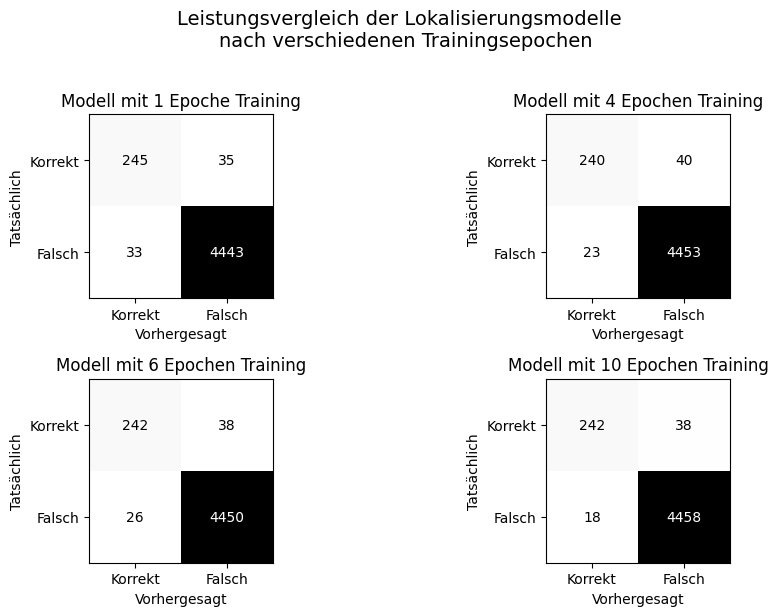

✅ Confusion matrix saved to: 05_Statistik/konfusionsmatrizen_1_4_6_10_epochs.png
✅ Precision/Recall/F1 saved to: 05_Statistik/loc_scores_data_1_4_6_10_epochs.csv
✅ Summary with accuracy saved to: 05_Statistik/loc_scores_summary_1_4_6_10_epochs.csv


In [9]:
import pandas as pd
import ast
import re
import math
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# === Parameters ===
image_path = f"05_Statistik/konfusionsmatrizen_1_4_6_10_epochs.png"
score_path = f"05_Statistik/loc_scores_data_1_4_6_10_epochs.csv"
summary_path = f"05_Statistik/loc_scores_summary_1_4_6_10_epochs.csv"

# === Load dataset ===
df = pd.read_csv(comparison_csv)

# === Helper functions ===
def to_list(val):
    if isinstance(val, list):
        return val
    if pd.isna(val):
        return []
    try:
        parsed = ast.literal_eval(val)
        return [] if parsed == ["not_found"] else parsed
    except:
        return [str(val).strip()]

def normalize_list(liste):
    return [str(item).strip().lower() for item in liste if isinstance(item, str)]

def label_tokens(label_list):
    return set(
        word.strip().lower()
        for label in label_list
        for word in str(label).split()
    )

def precision_recall_f1_accuracy(predicted, actual, label_space):
    pred_set = label_tokens(predicted)
    actual_set = label_tokens(actual)

    tp = len(pred_set & actual_set)
    fp = len(pred_set - actual_set)
    fn = len(actual_set - pred_set)
    tn = len(label_space - pred_set - actual_set)

    precision = tp / (tp + fp) if (tp + fp) else 0
    recall    = tp / (tp + fn) if (tp + fn) else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    accuracy  = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) else 0

    return precision, recall, f1, accuracy

# === Prepare columns ===
df["correct_location"] = df["correct_location"].apply(to_list)
df["all_words"] = df["all_words"].apply(to_list).apply(normalize_list)

# === Detect selected model columns ===
selected_models = ["ner_model_after_epoch_1", "ner_model_after_epoch_4", "ner_model_after_epoch_6", "ner_model_after_epoch_10"]
model_columns = [col for col in selected_models if col in df.columns]

print(f"🔍 Found model columns: {model_columns}")
for col in model_columns:
    df[col] = df[col].apply(to_list)

# === Plot setup: dynamic layout ===
num_models = len(model_columns)
cols = 2
rows = math.ceil(num_models / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 3 * rows))
axes = axes.flatten()

results = []
summary_data = []

for idx, col in enumerate(model_columns):
    name = col
    y_true = []
    y_pred = []

    # === Token-based confusion matrix using tokenized labels
    for _, row in df.iterrows():
        all_tokens = set(row["all_words"])
        true_set = label_tokens(row["correct_location"])
        pred_set = label_tokens(row[col])

        for token in all_tokens:
            y_true.append(token in true_set)
            y_pred.append(token in pred_set)

    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Korrekt", "Falsch"])
    disp.plot(ax=axes[idx], cmap="Greys", colorbar=False)

    match = re.search(r'epoch_(\d+)', name)
    epoche = match.group(1) if match else "?"
    titel = f"Modell mit {epoche} Epoche{'n' if epoche != '1' else ''} Training"
    axes[idx].set_title(titel)
    axes[idx].set_xlabel("Vorhergesagt")
    axes[idx].set_ylabel("Tatsächlich")

    # === Macro (global) scores
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # === Token-based row-wise scores
    df[[f"precision_{name}", f"recall_{name}", f"f1_{name}", f"accuracy_{name}"]] = df.apply(
        lambda row: pd.Series(
            precision_recall_f1_accuracy(
                row[col],
                row["correct_location"],
                set(row["all_words"])
            )
        ),
        axis=1
    )

    summary_data.append({
        "Model": name,
        "Precision": df[f"precision_{name}"].mean(),
        "Recall": df[f"recall_{name}"].mean(),
        "F1-Score": df[f"f1_{name}"].mean(),
        "Accuracy": df[f"accuracy_{name}"].mean()
    })

    results.append({
        "Model": name,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# === Hide unused axes ===
for i in range(len(model_columns), len(axes)):
    axes[i].set_visible(False)

# === Save matrix grid ===
plt.suptitle("Leistungsvergleich der Lokalisierungsmodelle  \nnach verschiedenen Trainingsepochen", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(image_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"✅ Confusion matrix saved to: {image_path}")

# === Save scores ===
pd.DataFrame(results).to_csv(score_path, index=False)
pd.DataFrame(summary_data).round(3).to_csv(summary_path, index=False)
print(f"✅ Precision/Recall/F1 saved to: {score_path}")
print(f"✅ Summary with accuracy saved to: {summary_path}")


In [10]:
import json
import pandas as pd

# === Load F1/metrics table ===
summary_path = "05_Statistik/loc_scores_summary_10_epochs.csv"
summary_df = pd.read_csv(summary_path)

# === Load central loss.json ===
loss_path = "02_Model/epoch_testing/final_metrics/loss.json"
with open(loss_path, "r", encoding="utf-8") as f:
    loss_values = json.load(f)

# === Match loss to models based on epoch number ===
def extract_epoch(model_name):
    import re
    match = re.search(r"epoch_(\d+)", model_name)
    return int(match.group(1)) if match else None

summary_df["Epoch"] = summary_df["Model"].apply(extract_epoch)
summary_df["Final_Loss"] = summary_df["Epoch"].apply(
    lambda epoch: round(loss_values[epoch - 1], 4) if epoch and 0 < epoch <= len(loss_values) else None
)

# === Drop Epoch column (optional) and sort by F1-Score ===
summary_df = summary_df.drop(columns=["Epoch"]).sort_values(by="F1-Score", ascending=False)

# === Save comparison CSV ===
output_path = "05_Statistik/loss_epoch_comparison.csv"
summary_df.to_csv(output_path, index=False)

# === Show table ===
print(summary_df[["Model", "F1-Score", "Final_Loss", "Precision", "Recall", "Accuracy"]])
print(f"\n✅ Comparison saved to: {output_path}")


                      Model  F1-Score  Final_Loss  Precision  Recall  Accuracy
1   ner_model_after_epoch_2     0.702  10536.0177      0.709   0.716     0.982
9  ner_model_after_epoch_10     0.697   1262.4393      0.714   0.696     0.984
2   ner_model_after_epoch_3     0.696   6020.7877      0.703   0.709     0.982
6   ner_model_after_epoch_7     0.690   1992.7595      0.696   0.700     0.982
4   ner_model_after_epoch_5     0.689   3029.6545      0.693   0.706     0.982
0   ner_model_after_epoch_1     0.688  28807.1266      0.695   0.703     0.982
3   ner_model_after_epoch_4     0.688   4086.5844      0.700   0.692     0.984
5   ner_model_after_epoch_6     0.688   2415.4942      0.697   0.699     0.982
8   ner_model_after_epoch_9     0.686   1615.4345      0.694   0.699     0.980
7   ner_model_after_epoch_8     0.685   1724.0625      0.692   0.699     0.982

✅ Comparison saved to: 05_Statistik/loss_epoch_comparison.csv


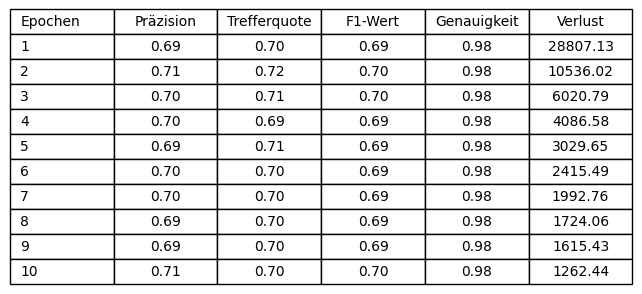

🖼️ Sortierte Tabelle gespeichert unter: 05_Statistik/model_epoch_summary_by_epoch_table.png


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# === Tabelle laden ===
df = pd.read_csv("05_Statistik/loss_epoch_comparison.csv")

# === Epoche aus dem Modellnamen extrahieren
df["Epochen"] = df["Model"].apply(lambda x: int(re.search(r"epoch_(\d+)", x).group(1)))

# === Umbenennen in deutsche Spaltennamen
df = df.rename(columns={
    "Precision": "Präzision",
    "Recall": "Trefferquote",
    "F1-Score": "F1-Wert",
    "Accuracy": "Genauigkeit",
    "Final_Loss": "Verlust"
})

# === Sortieren nach Epochen
df = df.sort_values(by="Epochen")

# === Spalten in gewünschte Reihenfolge bringen
df = df[["Epochen", "Präzision", "Trefferquote", "F1-Wert", "Genauigkeit", "Verlust"]]

# === Formatieren auf 2 Nachkommastellen als Strings
formatted_values = df.applymap(
    lambda x: f"{x:.2f}" if isinstance(x, float) else x
).values

# === Tabelle als Grafik erzeugen ===
width_cm = 17
width_inch = width_cm / 2.54
height_inch = 0.1 + 0.1 * len(df)

fig, ax = plt.subplots(figsize=(width_inch, height_inch))
ax.axis('off')

# Tabelle erstellen
table = ax.table(
    cellText=formatted_values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.0, 1.5)

# Spaltenbreite & Textausrichtung anpassen
for (row, col), cell in table.get_celld().items():
    if col == 0:  # "Epochen"
        cell.set_width(0.2)
        cell.set_text_props(ha='left')  # linksbündig
    else:
        cell.set_width(0.2)

# === Grafikpfad definieren ===
image_path = "05_Statistik/model_epoch_summary_by_epoch_table.png"

# === Grafik speichern & anzeigen ===
plt.savefig(image_path, bbox_inches='tight', dpi=300)
plt.show()
plt.close()

print(f"🖼️ Sortierte Tabelle gespeichert unter: {image_path}")


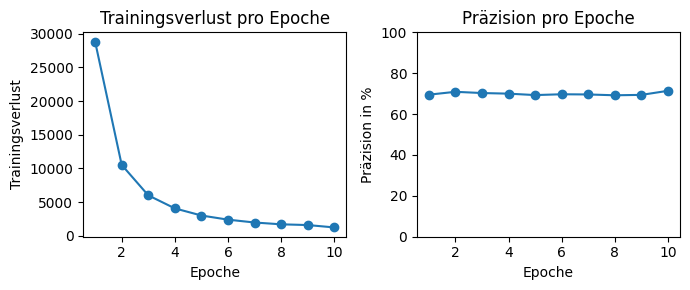

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# === Vergleichsdaten laden ===
csv_path = "05_Statistik/loss_epoch_comparison.csv"
df = pd.read_csv(csv_path)

# === Epoche extrahieren und sortieren ===
df["Epoche"] = df["Model"].str.extract(r"(\d+)").astype(int)
df = df.sort_values("Epoche")

# === Plot-Größe in Zoll (14.6 cm ≈ 5.75 inch) ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharex=True)

# --- Links: Loss ---
ax1.plot(df["Epoche"], df["Final_Loss"], marker='o')
ax1.set_title("Trainingsverlust pro Epoche")
ax1.set_xlabel("Epoche")
ax1.set_ylabel("Trainingsverlust")
ax1.grid(False)


# --- Rechts: Precision in Prozent ---
ax2.plot(df["Epoche"], df["Precision"] * 100, marker='o')
ax2.set_title("Präzision pro Epoche")
ax2.set_xlabel("Epoche")
ax2.set_ylabel("Präzision in %")
ax2.set_ylim(0, 100)
ax2.grid(False)

# Nur jede zweite Epoche auf der X-Achse anzeigen
ticks = [e for e in sorted(df["Epoche"].unique()) if e % 2 == 0]
ax1.set_xticks(ticks)
ax2.set_xticks(ticks)

plt.tight_layout()
plt.show()

